# Imports

In [1]:
from Models import *
from src.digit_functions import loadTestDigits, loadDigits
from src.sudoku_functions import loadSudokus
from src.sudoku_solver_functions import *
from src.feature_functions import *

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2 as cv

Model

In [2]:
pixelDensityModel = torch.load("./models/pixelDensity.pth")

Datasets

In [3]:
digitDataset = loadDigits("./data/digits")
print(f"(+) Digit dataset shape: ({digitDataset[0][0].shape}, {digitDataset[0][1].shape}), ({digitDataset[1][0].shape}, {digitDataset[1][1].shape})")
preprocessedDigitDataset = loadTestDigits("./data/digits/preprocessed")
print(f"(+) Preprocessed digit dataset shape: ({preprocessedDigitDataset[0].shape}, {preprocessedDigitDataset[1].shape})")
pixelDensityTransformedDigitDataset = loadTestDigits("./data/digits/transformed/pixelDensity")
print(f"(+) Pixel density tranformed digit dataset shape: ({pixelDensityTransformedDigitDataset[0].shape}, {pixelDensityTransformedDigitDataset[1].shape})")
sudokuDataset = loadSudokus("./data/sudokus")
print(f"(+) Sudoku dataset shape: ({sudokuDataset[0].shape}, {sudokuDataset[1].shape})")

(+) Reading data from .npy file...
(+) Digit loading finished
(+) Digit dataset shape: ((1496250, 40, 40), (1496250,)), ((78750, 40, 40), (78750,))
(+) Reading data from .npy file...
(+) Digit loading finished
(+) Preprocessed digit dataset shape: ((78750, 40, 40), (78750,))
(+) Reading data from .npy file...
(+) Digit loading finished
(+) Pixel density tranformed digit dataset shape: ((78750, 80), (78750,))
(+) Reading data from .npy file...
(+) Sudoku loading finished
(+) Sudoku dataset shape: ((55,), (55, 9, 9))


# Performance

Digits

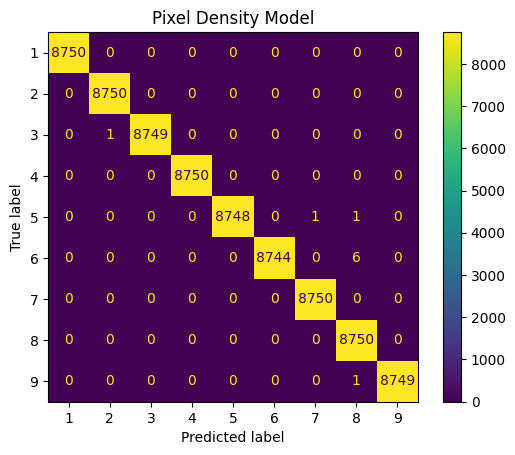

In [4]:
X = torch.tensor(pixelDensityTransformedDigitDataset[0], dtype=torch.float32)

_Y = pixelDensityModel(X)
_Y: np.ndarray = torch.argmax(_Y, dim=1).detach().numpy()

cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pixelDensityTransformedDigitDataset[1] - 1, _Y), display_labels = range(1, 10))
cm_display.plot()
plt.title("Pixel Density Model")
plt.savefig("./figures/pixelDensityModelConfusionMatrixOnDigits.png")

Sudokus

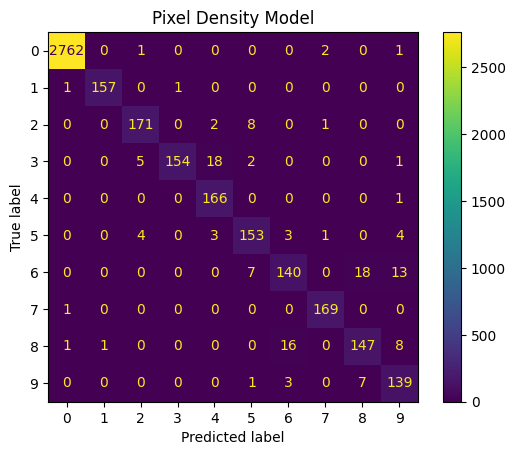

In [5]:
sudokus = (sudokuDataset[0].copy(), sudokuDataset[1].copy())
models = [pixelDensityModel]
featureFunctions = [pixelDensityFeatureFunction]

totalSudokusFound = 0
solvedSudokusCount = 0
notSolvedSudokus = []

trueDigits = []
predictedDigits = []

zeroPredeterminationErrors = {
    'trueZero': [],
    'predZero': []
}
wrongClassifications = {}
for i in range(1, 10):
    wrongClassifications[i] = []
correctClassifications = {}
for i in range(0, 10):
    correctClassifications[i] = []



for data, label in zip(sudokus[0], sudokus[1]):

    img = data.copy()
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sudokuImageGrayScale, sudokuContours = detectSudokuInGrayScaleImage(imgGray)

    if sudokuImageGrayScale is None or sudokuContours is None: 
        continue

    cells = retrieveCellsFromSudokuImage(sudokuImageGrayScale)

    sudoku = classifyCells(cells, models, featureFunctions)
    totalSudokusFound += 1

    wouldHaveSolved = True
    for xIndex in range(0, 9):
        for yIndex in range(0, 9):
            _y = sudoku[xIndex, yIndex]
            y = label[xIndex, yIndex]

            if _y != y: 
                wouldHaveSolved = False
                if y == 0:
                    zeroPredeterminationErrors['trueZero'].append(cells[xIndex, yIndex])
                else:
                    if _y == 0:
                        zeroPredeterminationErrors['predZero'].append(cells[xIndex, yIndex])
                    else:
                        wrongClassifications[y].append((cells[xIndex, yIndex], _y, y))
            else: 
                correctClassifications[y].append((cells[xIndex, yIndex], _y, y))
            predictedDigits.append(_y)
            trueDigits.append(y)
        
    if wouldHaveSolved:
        solvedSudokusCount += 1
    else: 
        notSolvedSudokus.append((data.copy(), label.copy()))

cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(trueDigits, predictedDigits), display_labels = range(0, 10))
cm_display.plot()
plt.title("Pixel Density Model")
plt.savefig("./figures/pixelDensityModelConfusionMatrixOnSudokus.png")